# 股票预测模型工作流

---
### 工作流说明
1.  **阶段零 (Setup)**: 导入库、加载配置。
2.  **阶段一 (Data Pipeline)**: 独立运行。负责处理并保存数据，生成 L2 特征数据缓存。
3.  **阶段二 (Model Pipeline)**: 独立运行。包含三个子步骤：
    - **2.1 HPO**: 自动调参。
    - **2.2 (预处理)**: 智能地加载或生成 L3 预处理数据缓存
    - **2.3 (模型训练)**: 使用 L3 缓存进行高效的模型训练。
    - **2.4 (评估)**: 对训练结果进行聚合与可视化。

## 0. 通用设置与导入

In [1]:
import os, sys, yaml, torch, joblib, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.preprocessing import StandardScaler

os.environ['PYOPENCL_CTX'] = '0'
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

try:
    from data_process.get_data import initialize_apis, shutdown_apis
    from data_process.save_data import run_data_pipeline, get_processed_data_path
    from model_builders.build_models import run_training_for_ticker, _walk_forward_split
    from model_builders.hpo_utils import run_hpo_for_ticker
    from model_builders.model_fuser import ModelFuser
    from model_builders.lstm_builder import LSTMBuilder
    print("INFO: 项目模型导入成功.")
except ImportError as e:
    print(f"WARNNING: 导入失败: {e}. 正在添加项目根目录...")
    project_root = str(Path().resolve()); sys.path.append(project_root) if project_root not in sys.path else None
    from data_process.get_data import initialize_apis, shutdown_apis
    from data_process.save_data import run_data_pipeline, get_processed_data_path
    from model_builders.build_models import run_training_for_ticker, _walk_forward_split
    from model_builders.hpo_utils import run_hpo_for_ticker
    from model_builders.model_fuser import ModelFuser
    from model_builders.lstm_builder import LSTMBuilder
    print("INFO: 导入成功.")

CONFIG_PATH = 'configs/config.yaml'
try:
    with open(CONFIG_PATH, 'r', encoding='utf-8') as f: config = yaml.safe_load(f)
    print(f"SUCCESS: 从 '{CONFIG_PATH}' 加载 Config.")
except FileNotFoundError:
    print(f"ERROR: 未找到 Config."); config = {}

if config:
    global_settings, strategy_config, hpo_config, default_model_params, stocks_to_process = (
        config.get('global_settings', {}), config.get('strategy_config', {}), 
        config.get('hpo_config', {}), config.get('default_model_params', {}), 
        config.get('stocks_to_process', [])
    )

C:\Users\Akari\AppData\Local\Temp\ipykernel_47076\1534436633.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


INFO: 项目模型导入成功.
SUCCESS: 从 'configs/config.yaml' 加载 Config.


# **阶段一：数据准备与特征工程**

In [2]:
print("--- 开始步骤 1: 数据准备 ---\n")
try:
    if config: initialize_apis(config); run_data_pipeline(config_path=CONFIG_PATH)
    else: print("ERROR: Config 为空.")
finally:
    shutdown_apis()

--- 开始步骤 1: 数据准备 ---

INFO: 尝试登陆 Baostock...
login success!
INFO: Baostock API 登录成功。SDK版本: 00.8.90
INFO: 未在配置中提供有效的 Tushare Token。将跳过宏观数据获取。
开始执行数据管道协调任务...
将使用配置文件: configs/config.yaml

需要为以下 7 只股票生成新数据: ['600519.SH', '000001.SZ', '688256.SH', '601606.SH', '000681.SZ', '603099.SH', '000100.SZ']
--- 开始批量特征生成 ---
针对特定股票: 7 生成特征.

--- Generating features for 贵州茅台 (600519.SH) ---
  - Running in Training Mode: Fetching historical data based on config.
  - Data window: Requesting data from 2010-09-30 to 2025-09-30.
  - [1/7] 正在从本地缓存加载 sh.600519 的原始日线数据...
  - INFO: Received data for 贵州茅台 from 2010-09-30 to 2025-09-30.
INFO: Starting feature calculation pipeline...
  - [Calculating Features] INFO: No technical indicators specified in config. Skipping Technical Indicators.
  - [Calculating Features] Running: Calendar Features...
  - [Calculating Features] INFO: No candlestick patterns specified in config. Skipping Candlestick Patterns.
  - [Calculating Features] Running: Statistical Features.

# **阶段二：模型训练与评估**

### 2.1 数据预加载与全局预处理 (L3 缓存)

In [ ]:
# train.ipynb -> "2.2 数据预加载与全局预处理" (最终 LSTM 修复版)

global_data_cache = {}
print("--- 开始步骤 2.2: 数据预加载与全局预处理 ---\\n")

L3_CACHE_DIR = Path(global_settings.get('output_dir', 'data/processed'))
L3_CACHE_DIR.mkdir(parents=True, exist_ok=True)
L3_CACHE_PATH = L3_CACHE_DIR / "_preprocessed_cache.joblib"

FORCE_REPROCESS = True      # 设置为 True 以重建缓存

if L3_CACHE_PATH.exists() and not FORCE_REPROCESS:
    print(f"INFO: 已找到 L3 缓存. 正在从 {L3_CACHE_PATH} 加载...")
    try:
        global_data_cache = joblib.load(L3_CACHE_PATH)
        print("SUCCESS: L3 缓存已加载到内存中.")
    except Exception as e:
        print(f"WARNNING: 加载 L3 缓存失败: {e}. 正在启动预处理.")
        global_data_cache = {}
else:
    print("INFO: 未找到 L3 缓存或正在强制重新处理. 正在启动预处理...\\n")

if not global_data_cache:
    print("INFO: 未找到 L3 缓存或缓存为空. 正在启动预处理...\\n")
    if config and stocks_to_process:
        lstm_builder_for_preprocessing = LSTMBuilder(config)
        
        for stock_info in tqdm(stocks_to_process, desc="Pre-processing Stocks"):
            ticker = stock_info.get('ticker'); keyword = stock_info.get('keyword', ticker)
            if not ticker: continue
            data_path = get_processed_data_path(stock_info, config)
            if not data_path.exists(): print(f"\\nERROR: 未找到 {keyword} 的 L2 数据."); continue
            
            df = pd.read_pickle(data_path); df.index.name = 'date'
            folds = _walk_forward_split(df, strategy_config)
            if not folds: print(f"\\nWARNNING: No folds for {keyword}."); continue

            preprocessed_folds_lgbm, preprocessed_folds_lstm = [], []
            label_col = global_settings.get('label_column', 'label_return')
            features_for_model = [
                c for c in df.columns 
                if c != label_col and not c.startswith('future_')
            ]
            print(f"  - 对于 {keyword}，已识别出 {len(features_for_model)} 个用于模型输入的有效特征.")

            for train_df, val_df in folds:
                # 1. 为 LGBM 准备数据 (不变)
                X_train_model, y_train = train_df[features_for_model], train_df[label_col]
                X_val_model, y_val = val_df[features_for_model], val_df[label_col]
                scaler_lgbm = StandardScaler()
                X_train_scaled = pd.DataFrame(scaler_lgbm.fit_transform(X_train_model), index=X_train_model.index, columns=features_for_model)
                X_val_scaled = pd.DataFrame(scaler_lgbm.transform(X_val_model), index=X_val_model.index, columns=features_for_model)
                preprocessed_folds_lgbm.append({'X_train_scaled': X_train_scaled, 'y_train': y_train, 'X_val_scaled': X_val_scaled, 'y_val': y_val})

                # 2. 为 LSTM 准备数据
                if 'lstm' in global_settings.get('models_to_train', []):
                    # --- 核心修正：为验证集拼接历史数据 ---
                    lstm_seq_len = lstm_builder_for_preprocessing.sequence_length
                    
                    # 确保 train_df 足够长
                    if len(train_df) < lstm_seq_len: continue

                    # 从 train_df 的末尾“借”一段历史
                    train_history_for_val = train_df.iloc[-lstm_seq_len:]
                    # 将历史和验证集合并，为 _create_sequences 提供连续的数据
                    combined_df_for_lstm_val = pd.concat([train_history_for_val, val_df])
                    # ---
                    
                    scaler_lstm = StandardScaler()
                    train_df_scaled = train_df.copy(); combined_df_for_lstm_val_scaled = combined_df_for_lstm_val.copy()
                    
                    train_df_scaled[features_for_model] = scaler_lstm.fit_transform(train_df[features_for_model])
                    combined_df_for_lstm_val_scaled[features_for_model] = scaler_lstm.transform(combined_df_for_lstm_val[features_for_model])

                    X_train_seq, y_train_seq, _ = lstm_builder_for_preprocessing._create_sequences(train_df_scaled, features_for_model)
                    
                    # 使用拼接后的数据为验证集创建序列
                    X_val_seq, y_val_seq, dates_val_seq = lstm_builder_for_preprocessing._create_sequences(combined_df_for_lstm_val_scaled, features_for_model)

                    preprocessed_folds_lstm.append({'X_train_tensor': torch.from_numpy(X_train_seq), 'y_train_tensor': torch.from_numpy(y_train_seq).unsqueeze(1), 'X_val_tensor': torch.from_numpy(X_val_seq), 'y_val_tensor': torch.from_numpy(y_val_seq).unsqueeze(1), 'y_val_seq': y_val_seq, 'dates_val_seq': dates_val_seq})
            
            global_data_cache[ticker] = {'full_df': df, 'lgbm_folds': preprocessed_folds_lgbm, 'lstm_folds': preprocessed_folds_lstm}
            print(f"  - Cached {len(preprocessed_folds_lgbm)} folds for LGBM and {len(preprocessed_folds_lstm)} folds for LSTM for {keyword}.")
        
        print(f"\\nINFO: 预处理已完成. 正在将 L3 缓存保存至 {L3_CACHE_PATH}...")
        try:
            joblib.dump(global_data_cache, L3_CACHE_PATH)
            print("SUCCESS: L3 缓存已保存.")
        except Exception as e:
            print(f"ERROR: 保存 L3 缓存失败: {e}")


--- Starting Stage 2.2: Data Pre-loading and Global Pre-processing ---\n
INFO: L3 cache not found or is being force-reprocessed. Starting pre-processing...\n
INFO: L3 cache not found or is empty. Starting pre-processing...\n
INFO: PyTorch LSTMBuilder will use device: CUDA


Pre-processing Stocks:   0%|          | 0/7 [00:00<?, ?it/s]

  - 对于 贵州茅台，已识别出 37 个用于模型输入的有效特征.
  - Cached 52 folds for LGBM and 52 folds for LSTM for 贵州茅台.
  - 对于 平安银行，已识别出 36 个用于模型输入的有效特征.
  - Cached 51 folds for LGBM and 51 folds for LSTM for 平安银行.
\nERROR: L2 data for 寒武纪-U not found.
  - 对于 长城军工，已识别出 37 个用于模型输入的有效特征.
  - Cached 23 folds for LGBM and 23 folds for LSTM for 长城军工.
  - 对于 视觉中国，已识别出 37 个用于模型输入的有效特征.
  - Cached 43 folds for LGBM and 43 folds for LSTM for 视觉中国.
  - 对于 长白山，已识别出 37 个用于模型输入的有效特征.
  - Cached 39 folds for LGBM and 39 folds for LSTM for 长白山.
  - 对于 TCL科技，已识别出 36 个用于模型输入的有效特征.
  - Cached 48 folds for LGBM and 48 folds for LSTM for TCL科技.
\nINFO: 预处理已完成. 正在将 L3 缓存保存至 data\processed\_preprocessed_cache.joblib...
SUCCESS: L3 缓存已保存.


### 2.2 超参数优化

In [ ]:
# train.ipynb -> "2.2 (可选) 超参数优化" (最终完整版)

RUN_HPO = True # 设为 True 以运行优化，False 则跳过

# --- 定义要进行 HPO 的模型列表 ---
MODELS_FOR_HPO = ['lgbm', 'lstm']

if RUN_HPO and config:
    hpo_tickers = hpo_config.get('tickers_for_hpo', [])
    
    if not hpo_tickers:
        print("INFO: 在配置文件中未指定用于 HPO 的股票，跳过此步骤。")
    elif 'global_data_cache' not in locals() or not global_data_cache:
        print("ERROR: 全局数据缓存 (global_data_cache) 为空。请先成功运行 2.1 预处理单元格。")
    else:
        print(f"--- 开始为模型 {MODELS_FOR_HPO} 和股票 {hpo_tickers} 进行超参数优化 ---\n")
        
        # 循环遍历要优化的每个模型类型
        for model_type_for_hpo in MODELS_FOR_HPO:
            print(f"\n" + "#"*80)
            print(f"# 开始为模型 [{model_type_for_hpo.upper()}] 进行 HPO")
            print("#"*80)
            
            hpo_results_list = []
            
            # --- 从模型专属配置或全局配置中获取 hpo_num_eval_folds ---
            model_hpo_config = hpo_config.get(f'{model_type_for_hpo}_hpo_config', {})
            num_eval_folds = model_hpo_config.get('hpo_num_eval_folds', hpo_config.get('hpo_num_eval_folds', 2))

            for ticker in hpo_tickers:
                stock_info = next((s for s in stocks_to_process if s['ticker'] == ticker), None)
                if not stock_info:
                    print(f"WARNNING: 未在 'stocks_to_process' 中找到 HPO 股票 {ticker} 的配置。跳过。")
                    continue
                
                keyword = stock_info.get('keyword', ticker)

                if ticker not in global_data_cache:
                    print(f"ERROR: 预处理数据缓存中未找到 {keyword} 的数据。请先成功运行 2.1 单元格。跳过。")
                    continue

                all_preprocessed_folds = global_data_cache[ticker].get(f'{model_type_for_hpo}_folds', [])
                if not all_preprocessed_folds:
                    print(f"WARNNING: 缓存中未找到 {keyword} 的 '{model_type_for_hpo}' 预处理数据。跳过 HPO。")
                    continue
                
                # 使用正确的 num_eval_folds 来切片数据
                hpo_folds_data = all_preprocessed_folds[-num_eval_folds:]
                
                print(f"\nINFO: 已为 {keyword} 加载最后 {len(hpo_folds_data)} 个 folds 用于 {model_type_for_hpo.upper()} HPO。")

                hpo_run_config = {
                    'global_settings': global_settings, 'strategy_config': strategy_config,
                    'default_model_params': default_model_params, 'stocks_to_process': [stock_info],
                    'hpo_config': hpo_config
                }
                
                best_params, best_value = run_hpo_for_ticker(
                    preprocessed_folds=hpo_folds_data,
                    ticker=ticker,
                    config=hpo_run_config,
                    model_type=model_type_for_hpo
                    # n_trials 会在 run_hpo_for_ticker 函数内部自动获取
                )
                
                if best_params and best_value is not None:
                    hpo_results_list.append({'ticker': ticker, 'keyword': keyword, 'best_score': best_value, **best_params})
            
            if hpo_results_list:
                # --- 实现“冠军排行榜”更新逻辑 ---
                hpo_log_dir = Path("hpo_logs")
                hpo_log_dir.mkdir(exist_ok=True)
                # 每个模型一个独立的冠军榜文件
                hpo_best_results_path = hpo_log_dir / f"hpo_best_results_{model_type_for_hpo}.csv"
                
                current_hpo_df = pd.DataFrame(hpo_results_list).set_index('ticker')

                if hpo_best_results_path.exists():
                    print(f"\nINFO: 正在加载 [{model_type_for_hpo.upper()}] 的历史最佳 HPO 结果...")
                    historical_best_df = pd.read_csv(hpo_best_results_path).set_index('ticker')
                    
                    for ticker, current_row in current_hpo_df.iterrows():
                        if ticker not in historical_best_df.index or current_row['best_score'] > historical_best_df.loc[ticker, 'best_score']:
                            keyword = current_row.get('keyword', ticker)
                            historical_score = historical_best_df.loc[ticker, 'best_score'] if ticker in historical_best_df.index else 'N/A'
                            print(f"  - 新纪录! [{model_type_for_hpo.upper()}] {keyword} 的最佳分数从 {historical_score if isinstance(historical_score, str) else f'{historical_score:.4f}'} 提升至 {current_row['best_score']:.4f}.")
                            historical_best_df.loc[ticker] = current_row
                    final_best_df = historical_best_df
                else:
                    print(f"\nINFO: 未找到 [{model_type_for_hpo.upper()}] 的历史 HPO 结果，将本次结果作为初始最佳记录。")
                    final_best_df = current_hpo_df

                final_best_df.to_csv(hpo_best_results_path)
                print(f"SUCCESS: 最新的 [{model_type_for_hpo.upper()}] HPO 冠军榜已保存至 {hpo_best_results_path}")
                
                # --- 展示和应用最终的参数 ---
                PARAM_MAP_CN = {'best_score': '最佳分数 (ICIR)', 'keyword': '股票名称', 'num_leaves': '叶子节点数', 'learning_rate': '学习率', 'min_child_samples': '叶节点最小样本数', 'feature_fraction': '特征采样比例', 'bagging_fraction': '数据采样比例', 'reg_alpha': 'L1正则化', 'reg_lambda': 'L2正则化', 'units_1': '隐藏层1单元数', 'units_2': '隐藏层2单元数', 'dropout': 'Dropout率'}
                display_df = final_best_df.reset_index().rename(columns=PARAM_MAP_CN)
                if '股票名称' in display_df.columns: display_df = display_df.set_index(['ticker', '股票名称'])
                
                print(f"--- {model_type_for_hpo.upper()} HPO 最佳参数冠军榜 ---")
                display(display_df.style.format({'最佳分数 (ICIR)': '{:.4f}'}).background_gradient(cmap='viridis', subset=['最佳分数 (ICIR)']))
                
                param_cols_original = [c for c in hpo_results_list[0].keys() if c not in ['ticker', 'keyword', 'best_score']]
                final_hpo_params = final_best_df[param_cols_original].mean().to_dict()
                average_best_score = final_best_df['best_score'].mean()
                
                for p in ['num_leaves', 'min_child_samples', 'units_1', 'units_2']:
                    if p in final_hpo_params: final_hpo_params[p] = int(round(final_hpo_params[p]))
                
                param_key = f"{model_type_for_hpo}_params"
                config['default_model_params'][param_key].update(final_hpo_params)
                default_model_params[param_key] = config['default_model_params'][param_key]
                
                print(f"--- {model_type_for_hpo.upper()} HPO 综合结果 ---")
                print(f"本轮 HPO 冠军榜平均最高分 (ICIR): {average_best_score:.4f}")
                print(f"将用于后续训练的【{model_type_for_hpo.upper()} 平均参数】如下:")
                print(yaml.dump(default_model_params[param_key], allow_unicode=True))

else:
    print("INFO: 跳过 HPO 步骤。")

### 2.3 模型训练

In [5]:
FORCE_RETRAIN = False
all_ic_history = []

print("--- 开始模型训练 ---\\n")
if config and stocks_to_process:
    models_to_train = global_settings.get('models_to_train', ['lgbm', 'lstm'])
    stock_iterator = tqdm(stocks_to_process, desc="Processing Stocks")

    for stock_info in stock_iterator:
        ticker = stock_info.get('ticker')
        
        if not ticker or ticker not in global_data_cache:
            continue
        
        keyword = stock_info.get('keyword', ticker)
        stock_iterator.set_description(f"Processing {keyword}")
        
        # 从缓存中获取该股票的所有数据
        cached_stock_data = global_data_cache[ticker]
        full_df = cached_stock_data['full_df']
        
        for model_type in models_to_train:
            # --- 核心修正：根据 model_type 动态构建正确的键名 ---
            folds_key = f"{model_type}_folds"
            preprocessed_folds = cached_stock_data.get(folds_key)
            
            if not preprocessed_folds:
                print(f"\\nWARNNING: 未找到 {keyword} 模型 '{model_type}' 的预处理 folds. 跳过.")
                continue
            # --- 修正结束 ---

            run_config = {
                'global_settings': global_settings, 'strategy_config': strategy_config,
                'default_model_params': default_model_params, 'stocks_to_process': [stock_info],
                'full_df_for_final_model': full_df
            }

            ic_history = run_training_for_ticker(
                preprocessed_folds=preprocessed_folds,
                ticker=ticker,
                model_type=model_type,
                config=run_config, 
                force_retrain=FORCE_RETRAIN,
                keyword=keyword
            )
            
            if ic_history is not None and not ic_history.empty:
                all_ic_history.append(ic_history)
else:
    print("ERROR: Config 或 stocks_to_process 为空.")

    - Quantile 0.95: Finished. Best iter: [1]
    - Quantile 0.05: Finished. Best iter: [149]
    - Quantile 0.5: Finished. Best iter: [151]
    - Quantile 0.95: Finished. Best iter: [10]
    - Quantile 0.05: Finished. Best iter: [22]
    - Quantile 0.5: Finished. Best iter: [2]
    - Quantile 0.95: Finished. Best iter: [2]
    - Quantile 0.05: Finished. Best iter: [198]
    - Quantile 0.5: Finished. Best iter: [36]
    - Quantile 0.95: Finished. Best iter: [1]
    - Quantile 0.05: Finished. Best iter: [131]
    - Quantile 0.5: Finished. Best iter: [6]
    - Quantile 0.95: Finished. Best iter: [6]
    - Quantile 0.05: Finished. Best iter: [200]
    - Quantile 0.5: Finished. Best iter: [70]
    - Quantile 0.95: Finished. Best iter: [2]
    - Quantile 0.05: Finished. Best iter: [1]
    - Quantile 0.5: Finished. Best iter: [2]
    - Quantile 0.95: Finished. Best iter: [35]
    - Quantile 0.05: Finished. Best iter: [200]
    - Quantile 0.5: Finished. Best iter: [1]
    - Quantile 0.95: Fin

Training LSTM on TCL科技:   0%|          | 0/47 [00:00<?, ?it/s]

    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.005490 at epoch 36


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.003501 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.001180 at epoch 19


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.032795 at epoch 12


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.004435 at epoch 8


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.029117 at epoch 29


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.084321 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.005744 at epoch 4


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.016914 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.011194 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.008311 at epoch 7


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.002204 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.000732 at epoch 4


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.000378 at epoch 16


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.010883 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.026273 at epoch 9


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.008431 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.007518 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.003354 at epoch 9


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.001686 at epoch 11


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.065917 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.013449 at epoch 3


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.004425 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.008071 at epoch 18


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.064568 at epoch 48


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.092167 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.009821 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.007326 at epoch 3


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.020607 at epoch 37


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.018926 at epoch 48


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.011481 at epoch 16


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.002149 at epoch 32


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.030985 at epoch 2


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.007535 at epoch 6


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.004526 at epoch 10


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.015041 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.005227 at epoch 2


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.005051 at epoch 2


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.011512 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.003566 at epoch 4


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.003853 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.001857 at epoch 21


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.010736 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.026734 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.001928 at epoch 4


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.004435 at epoch 1


    - Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

    - Fold finished. Best validation loss: 0.003021 at epoch 1
SUCCESS: Out-of-Fold predictions saved to models\000100.SZ\lstm_oof_preds.csv
INFO: Training final model for TCL科技 (000100.SZ) on all data...


    - Final Model Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

### 2.3.5 融合模型训练

In [5]:
print("\\n--- Starting Stage 2.3.5: Training Fusion Meta-Model ---\\n")

if config and stocks_to_process:
    fuser_iterator = tqdm(stocks_to_process, desc="Training Fusers")
    for stock_info in fuser_iterator:
        ticker = stock_info.get('ticker')
        keyword = stock_info.get('keyword', ticker)
        fuser_iterator.set_description(f"Training Fuser for {keyword}")
        if not ticker: continue

        # 1. 实例化融合器
        # 我们需要一个包含了所有相关配置的 config 字典
        run_config = {
            'global_settings': global_settings, 
            'strategy_config': strategy_config,
            'default_model_params': default_model_params,
            'stocks_to_process': [stock_info]
        }
        fuser = ModelFuser(ticker, run_config)
        
        # 2. 调用训练方法
        # 新的 ModelFuser.train() 方法现在是自给自足的，它会自己去加载 OOF 和 y_true
        fuser.train()

\n--- Starting Stage 2.3.5: Training Fusion Meta-Model ---\n


Training Fusers:   0%|          | 0/7 [00:00<?, ?it/s]


--- 正在为 600519.SH 训练融合元模型... ---
INFO: 样本量为 2880，自动选择 5 折交叉验证。
INFO: 使用 Ridge 作为元模型。
  - 交叉验证 IC 分数: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000'], 平均值: 0.0000
  - IC 稳定性分数 (变异系数): 0.0000

--- 训练后性能评估 ---
  - 融合模型 IC: 0.0000
  - LGBM 单独 IC: 0.4432
  - LSTM 单独 IC: 0.4155
WARNNING: 融合模型性能未超越最佳单一模型。将回退到简单加权策略。

--- 正在为 000001.SZ 训练融合元模型... ---
INFO: 样本量为 2880，自动选择 5 折交叉验证。
INFO: 使用 Ridge 作为元模型。
  - 交叉验证 IC 分数: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000'], 平均值: 0.0000
  - IC 稳定性分数 (变异系数): 0.0000

--- 训练后性能评估 ---
  - 融合模型 IC: 0.0000
  - LGBM 单独 IC: 0.2427
  - LSTM 单独 IC: 0.2642
WARNNING: 融合模型性能未超越最佳单一模型。将回退到简单加权策略。

--- 正在为 688256.SH 训练融合元模型... ---
WARNNING: 未找到 lgbm 的 OOF 预测文件: models\688256.SH\lgbm_oof_preds.csv。
ERROR: 基础模型的 OOF 预测不完整，无法训练融合模型。

--- 正在为 601606.SH 训练融合元模型... ---
INFO: 样本量为 1140，自动选择 5 折交叉验证。
INFO: 使用 Ridge 作为元模型。
  - 交叉验证 IC 分数: ['0.0000', '0.0000', '0.0000', '0.0000', '0.0000'], 平均值: 0.0000
  - IC 稳定性分数 (变异系数): 0.0000

--- 训练后性能评估 ---
  - 融合模型 IC: 0.0000
  - 

### 2.4 结果聚合、评估与可视化


--- 开始步骤 2.4: 结果聚合、评估与可视化 ---

--- 模型性能评估总结 ---


,ticker_name,model_type,mean,std,icir
0,TCL科技,lgbm,0.2967,0.4437,0.6687
1,TCL科技,lstm,0.2562,0.5063,0.5059
2,平安银行,lgbm,0.3061,0.3624,0.8445
3,平安银行,lstm,0.3983,0.3982,1.0003
4,视觉中国,lgbm,0.3887,0.3815,1.0189
5,视觉中国,lstm,0.5148,0.3548,1.4510
6,贵州茅台,lgbm,0.3437,0.3962,0.8674
7,贵州茅台,lstm,0.3851,0.3739,1.0299
8,长城军工,lgbm,0.2461,0.4785,0.5143
9,长城军工,lstm,0.3956,0.4064,0.9733


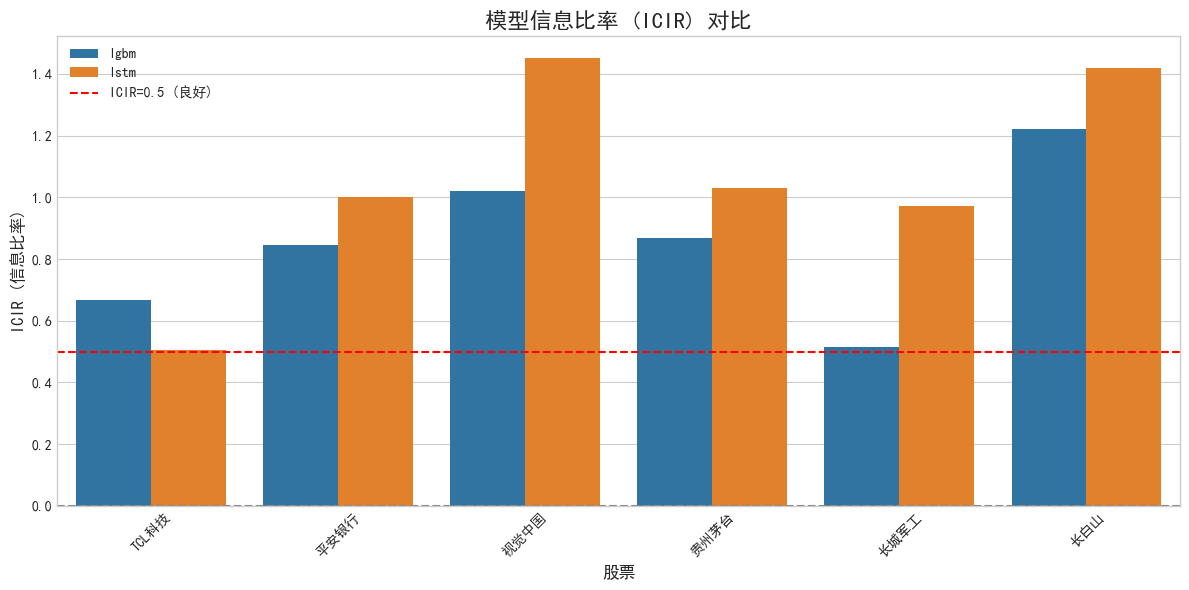

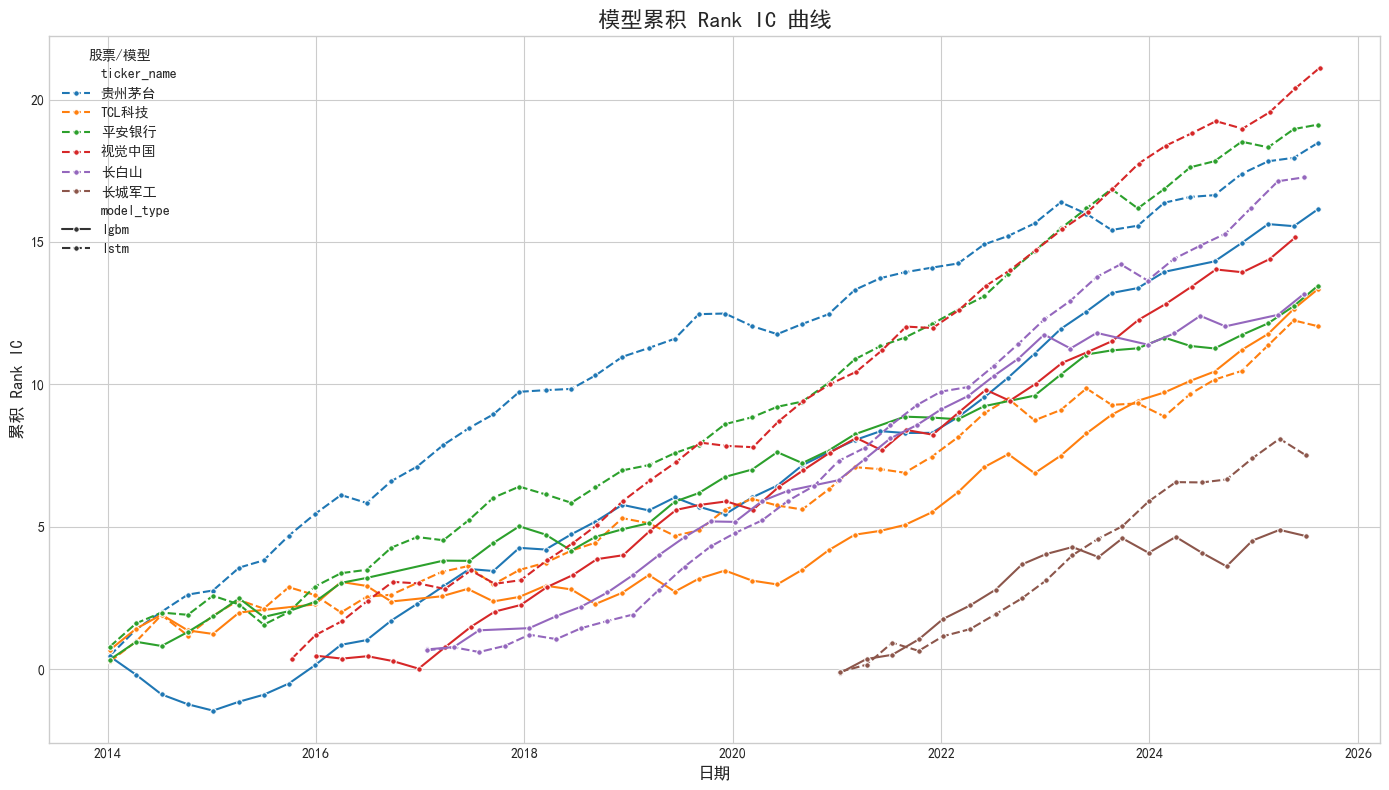

In [7]:
print("\n--- 开始步骤 2.4: 结果聚合、评估与可视化 ---")
if all_ic_history:
    full_ic_df = pd.concat(all_ic_history)
    full_ic_df['ticker_name'] = full_ic_df['ticker'].map({s['ticker']: s.get('keyword', s['ticker']) for s in stocks_to_process})
    
    # 聚合评估结果
    evaluation_summary = full_ic_df.groupby(['ticker_name', 'model_type'])['rank_ic'].agg(['mean', 'std']).reset_index()
    evaluation_summary['icir'] = evaluation_summary['mean'] / evaluation_summary['std']
    
    # --- 1. 打印和显示评估表格 ---
    print("\n--- 模型性能评估总结 ---")
    display(evaluation_summary.style.format({
        'mean': '{:.4f}', 'std': '{:.4f}', 'icir': '{:.4f}'
    }).background_gradient(cmap='viridis', subset=['icir']))

    # --- 2. 绘制 ICIR 对比图 ---
    plt.figure(figsize=(12, 6))
    sns.barplot(data=evaluation_summary, x='ticker_name', y='icir', hue='model_type')
    plt.title('模型信息比率 (ICIR) 对比', fontsize=16)
    plt.xlabel('股票', fontsize=12)
    plt.ylabel('ICIR (信息比率)', fontsize=12)
    plt.axhline(0, color='grey', linestyle='--')
    plt.axhline(0.5, color='red', linestyle='--', label='ICIR=0.5 (良好)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- 3. 绘制累积 IC 曲线图 ---
    plot_df = full_ic_df.copy()
    plot_df['date'] = pd.to_datetime(plot_df['date'])
    plot_df.sort_values('date', inplace=True)
    plot_df['cumulative_ic'] = plot_df.groupby(['ticker_name', 'model_type'])['rank_ic'].cumsum()
    
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=plot_df, x='date', y='cumulative_ic', hue='ticker_name', style='model_type', marker='o', markersize=4, linestyle='--')
    plt.title('模型累积 Rank IC 曲线', fontsize=16)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('累积 Rank IC', fontsize=12)
    plt.legend(title='股票/模型')
    plt.tight_layout()
    plt.show()

else:
    print("\nWARNNING: 训练期间未生成 IC 历史。跳过汇总和评估.")